<a href="https://colab.research.google.com/github/AlexandreAdam/Censai/blob/eager2.4/notebooks/train_rim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!git clone https://github.com/AlexandreAdam/Censai.git
%cd Censai
!git checkout eager2.4 
!python setup.py install
!pip install wandb

# wanb login
%pip install wandb -q
%pip install tensorflow_addons
import wandb


In [1]:
import tensorflow as tf
from censai.physical_model import PhysicalModel
from censai.data_generator import NISGenerator
from censai.rim_unet import RIM
from censai.utils import nullwriter
import os
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from tqdm import tqdm
%matplotlib inline
# os.mkdir("logs") # run only once/

In [2]:
def main(args):
#     if wndb:
#         config = wandb.config
#         config.learning_rate = args.lr
#         config.batch_size = args.batch_size
#         config.epochs = args.epochs
#         config.architecture="Double RIM Unet"
#         config.update(args)
    gen = NISGenerator(args.total_items, args.batch_size, model="rim", pixels=args.pixels) #TODO add noise to observed lens
    gen_test = NISGenerator(args.validation, args.validation, train=False, model="rim", pixels=args.pixels)
    phys = PhysicalModel(pixels=args.pixels, noise_rms=args.noise_rms)
    if "rim" in args.keys():
        rim = args.rim
    else:
        rim = RIM(phys, args.batch_size, args.time_steps, args.pixels, strides=args.strides, kappalog=args.kappalog)
    optim = tf.optimizers.Adam(args.lr)
	# setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, args.logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        test_writer = nullwriter()
        train_writer = nullwriter()

    epoch_loss = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    for epoch in tqdm(range(args.epochs)):
        epoch_loss.reset_states()
        with train_writer.as_default():
            for batch, (X, source, kappa) in enumerate(gen):
                with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:
                    tape.watch(rim.model_1.trainable_variables)
                    tape.watch(rim.model_2.trainable_variables)
                    cost = rim.cost_function(X, source, kappa)
                gradient1 = tape.gradient(cost, rim.model_1.trainable_variables)
                gradient2 = tape.gradient(cost, rim.model_2.trainable_variables)
                # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
                optim.apply_gradients(zip(gradient1, rim.model_1.trainable_variables)) # backprop
                optim.apply_gradients(zip(gradient2, rim.model_2.trainable_variables))

                #========== Summary and logs ==========
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            # tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
        with test_writer.as_default():
            for (X, source, kappa) in gen_test:
                test_cost = rim.cost_function(X, source,  kappa)
            tf.summary.scalar("MSE", test_cost, step=step)
        print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_cost.numpy():.3e}") #| learning rate {optim.lr(step).numpy():.2e}")
        if test_cost < best_loss - args.tolerance:
            best_loss = test_cost
            patience = args.patience
        else:
            patience -= 1
        if patience == 0:
            print("Reached patience")
            break
    return gen, gen_test, rim, epoch_loss.result()

In [3]:
# quick hack to make a config like args of ArgumentParser
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

lr = 1e-4
decay_steps=100
decay_rate=1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
init_range = 0.1
# initializer = tf.keras.initializers.RandomUniform(minval=-init_range, maxval=init_range)
# initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=init_range)
initializer = tf.keras.initializers.GlorotNormal()
# setup hyperparameter and other configs
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
Config = AttrDict()
Config.update({
    #hparams
    "epochs": 100,
    "lr": lr, # initial learning rate
    "decay_steps": decay_steps,
    "decay_rate": decay_rate,
    "batch_size": 10,
    "kappalog": True,
    "clipping": False,
    "pixels": 64,
    "strides": 2,
    "noise_rms": 0.1,
    "time_steps": 16,
    # "initializer_range":init_range,
    "initializer_type": "glorot_normal",
    "optimizer_name": "Adam",
    #configs
    "total_items": 100, # items per epochs
    "logdir": "none",
    "logname": date,
    "validation": 10,
    "patience": 10,
    "tolerance": 0,
    # "schedule": lr_schedule,
    "initializer": initializer,
    "optimizer": tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#     "rim": rim # only works if next cell has already ran, this is a hack for checkpointing in a live session
})


In [11]:
# wndb = False
# wandb.init(project="censai", entity="adam-alexandre01123", sync_tensorboard=True)
gen, gen_test, rim, loss = main(Config)

  1%|          | 1/100 [02:37<4:19:47, 157.45s/it]

epoch 0 | train loss 2.054e+00 | val loss 4.629e-01


  2%|▏         | 2/100 [03:06<2:13:44, 81.88s/it] 

epoch 1 | train loss 3.154e-01 | val loss 2.116e-01


  3%|▎         | 3/100 [03:35<1:33:33, 57.87s/it]

epoch 2 | train loss 1.624e-01 | val loss 1.379e-01


  4%|▍         | 4/100 [04:05<1:14:44, 46.71s/it]

epoch 3 | train loss 1.280e-01 | val loss 1.280e-01


  5%|▌         | 5/100 [04:34<1:03:47, 40.29s/it]

epoch 4 | train loss 1.258e-01 | val loss 1.188e-01


  6%|▌         | 6/100 [05:03<57:03, 36.42s/it]  

epoch 5 | train loss 1.132e-01 | val loss 1.168e-01


  7%|▋         | 7/100 [05:32<52:48, 34.07s/it]

epoch 6 | train loss 1.166e-01 | val loss 1.119e-01


  8%|▊         | 8/100 [06:01<49:57, 32.58s/it]

epoch 7 | train loss 1.101e-01 | val loss 1.088e-01


  9%|▉         | 9/100 [06:30<47:34, 31.37s/it]

epoch 8 | train loss 1.078e-01 | val loss 1.056e-01


 10%|█         | 10/100 [06:59<45:55, 30.62s/it]

epoch 9 | train loss 1.010e-01 | val loss 1.037e-01


 11%|█         | 11/100 [07:28<44:42, 30.14s/it]

epoch 10 | train loss 9.961e-02 | val loss 1.014e-01


 12%|█▏        | 12/100 [07:57<43:46, 29.85s/it]

epoch 11 | train loss 1.006e-01 | val loss 9.799e-02


 13%|█▎        | 13/100 [08:26<43:00, 29.66s/it]

epoch 12 | train loss 9.727e-02 | val loss 8.780e-02


 14%|█▍        | 14/100 [08:56<42:17, 29.50s/it]

epoch 13 | train loss 8.043e-02 | val loss 7.650e-02


 15%|█▌        | 15/100 [09:25<41:42, 29.44s/it]

epoch 14 | train loss 7.202e-02 | val loss 6.261e-02


 16%|█▌        | 16/100 [09:54<41:02, 29.32s/it]

epoch 15 | train loss 5.615e-02 | val loss 5.103e-02


 17%|█▋        | 17/100 [10:23<40:30, 29.28s/it]

epoch 16 | train loss 4.382e-02 | val loss 3.527e-02


 18%|█▊        | 18/100 [10:52<39:49, 29.14s/it]

epoch 17 | train loss 3.181e-02 | val loss 2.519e-02


 19%|█▉        | 19/100 [11:21<39:18, 29.12s/it]

epoch 18 | train loss 2.528e-02 | val loss 2.480e-02


 20%|██        | 20/100 [11:50<38:48, 29.10s/it]

epoch 19 | train loss 2.469e-02 | val loss 2.258e-02


 21%|██        | 21/100 [12:19<38:24, 29.17s/it]

epoch 20 | train loss 2.203e-02 | val loss 2.656e-02


 22%|██▏       | 22/100 [12:48<37:51, 29.12s/it]

epoch 21 | train loss 2.240e-02 | val loss 2.197e-02


 23%|██▎       | 23/100 [13:17<37:19, 29.09s/it]

epoch 22 | train loss 2.372e-02 | val loss 2.501e-02


 24%|██▍       | 24/100 [13:47<36:55, 29.15s/it]

epoch 23 | train loss 1.981e-02 | val loss 1.857e-02


 25%|██▌       | 25/100 [14:16<36:35, 29.27s/it]

epoch 24 | train loss 1.919e-02 | val loss 1.938e-02


 26%|██▌       | 26/100 [14:45<36:06, 29.28s/it]

epoch 25 | train loss 2.042e-02 | val loss 1.796e-02


 27%|██▋       | 27/100 [15:15<35:34, 29.23s/it]

epoch 26 | train loss 1.866e-02 | val loss 1.694e-02


 28%|██▊       | 28/100 [15:44<35:12, 29.34s/it]

epoch 27 | train loss 1.790e-02 | val loss 1.855e-02


 29%|██▉       | 29/100 [16:13<34:36, 29.25s/it]

epoch 28 | train loss 2.070e-02 | val loss 1.706e-02


 30%|███       | 30/100 [16:42<34:02, 29.17s/it]

epoch 29 | train loss 1.727e-02 | val loss 1.903e-02


 31%|███       | 31/100 [17:11<33:26, 29.08s/it]

epoch 30 | train loss 1.763e-02 | val loss 1.600e-02


 32%|███▏      | 32/100 [17:40<32:48, 28.95s/it]

epoch 31 | train loss 1.681e-02 | val loss 1.707e-02


 33%|███▎      | 33/100 [18:09<32:31, 29.13s/it]

epoch 32 | train loss 1.842e-02 | val loss 1.582e-02


 34%|███▍      | 34/100 [18:38<31:55, 29.02s/it]

epoch 33 | train loss 1.789e-02 | val loss 1.650e-02


 35%|███▌      | 35/100 [19:07<31:25, 29.01s/it]

epoch 34 | train loss 1.680e-02 | val loss 1.556e-02


 36%|███▌      | 36/100 [19:36<31:04, 29.14s/it]

epoch 35 | train loss 1.670e-02 | val loss 1.664e-02


 37%|███▋      | 37/100 [20:06<30:33, 29.11s/it]

epoch 36 | train loss 1.830e-02 | val loss 1.640e-02


 38%|███▊      | 38/100 [20:35<30:02, 29.07s/it]

epoch 37 | train loss 1.908e-02 | val loss 1.843e-02


 39%|███▉      | 39/100 [21:03<29:28, 28.99s/it]

epoch 38 | train loss 1.775e-02 | val loss 1.843e-02


 40%|████      | 40/100 [21:32<28:58, 28.98s/it]

epoch 39 | train loss 1.696e-02 | val loss 1.674e-02


 41%|████      | 41/100 [22:01<28:30, 28.99s/it]

epoch 40 | train loss 1.850e-02 | val loss 1.484e-02


 42%|████▏     | 42/100 [22:31<28:08, 29.11s/it]

epoch 41 | train loss 1.702e-02 | val loss 1.762e-02


 43%|████▎     | 43/100 [23:00<27:35, 29.05s/it]

epoch 42 | train loss 1.993e-02 | val loss 1.553e-02


 44%|████▍     | 44/100 [23:29<27:06, 29.04s/it]

epoch 43 | train loss 1.771e-02 | val loss 1.927e-02


 45%|████▌     | 45/100 [23:58<26:39, 29.09s/it]

epoch 44 | train loss 1.806e-02 | val loss 1.599e-02


 46%|████▌     | 46/100 [24:28<26:20, 29.28s/it]

epoch 45 | train loss 1.573e-02 | val loss 1.726e-02


 47%|████▋     | 47/100 [24:57<25:56, 29.36s/it]

epoch 46 | train loss 1.718e-02 | val loss 1.516e-02


 48%|████▊     | 48/100 [25:27<25:33, 29.49s/it]

epoch 47 | train loss 1.704e-02 | val loss 1.464e-02


 49%|████▉     | 49/100 [25:57<25:18, 29.77s/it]

epoch 48 | train loss 1.632e-02 | val loss 1.702e-02


 50%|█████     | 50/100 [26:29<25:16, 30.32s/it]

epoch 49 | train loss 1.667e-02 | val loss 1.465e-02


 51%|█████     | 51/100 [27:00<25:01, 30.64s/it]

epoch 50 | train loss 1.682e-02 | val loss 1.463e-02


 52%|█████▏    | 52/100 [27:32<24:43, 30.91s/it]

epoch 51 | train loss 1.536e-02 | val loss 1.505e-02


 53%|█████▎    | 53/100 [28:04<24:24, 31.16s/it]

epoch 52 | train loss 1.563e-02 | val loss 1.440e-02


 54%|█████▍    | 54/100 [28:35<23:55, 31.20s/it]

epoch 53 | train loss 1.623e-02 | val loss 1.509e-02


 55%|█████▌    | 55/100 [29:06<23:25, 31.23s/it]

epoch 54 | train loss 1.623e-02 | val loss 1.589e-02


 56%|█████▌    | 56/100 [29:38<22:57, 31.31s/it]

epoch 55 | train loss 1.653e-02 | val loss 1.527e-02


 57%|█████▋    | 57/100 [30:09<22:27, 31.34s/it]

epoch 56 | train loss 1.604e-02 | val loss 1.430e-02


 58%|█████▊    | 58/100 [30:41<21:58, 31.40s/it]

epoch 57 | train loss 1.450e-02 | val loss 1.458e-02


 59%|█████▉    | 59/100 [31:12<21:27, 31.40s/it]

epoch 58 | train loss 1.617e-02 | val loss 1.433e-02


 60%|██████    | 60/100 [31:44<21:00, 31.52s/it]

epoch 59 | train loss 1.596e-02 | val loss 1.661e-02


 61%|██████    | 61/100 [32:15<20:25, 31.42s/it]

epoch 60 | train loss 1.586e-02 | val loss 1.543e-02


 62%|██████▏   | 62/100 [32:47<19:57, 31.51s/it]

epoch 61 | train loss 1.531e-02 | val loss 1.603e-02


 63%|██████▎   | 63/100 [33:18<19:26, 31.54s/it]

epoch 62 | train loss 1.764e-02 | val loss 1.441e-02


 64%|██████▍   | 64/100 [33:50<18:54, 31.52s/it]

epoch 63 | train loss 1.537e-02 | val loss 1.557e-02


 65%|██████▌   | 65/100 [34:21<18:23, 31.54s/it]

epoch 64 | train loss 1.506e-02 | val loss 1.429e-02


 66%|██████▌   | 66/100 [34:53<17:51, 31.51s/it]

epoch 65 | train loss 1.696e-02 | val loss 1.521e-02


 67%|██████▋   | 67/100 [35:24<17:20, 31.54s/it]

epoch 66 | train loss 1.434e-02 | val loss 1.429e-02


 68%|██████▊   | 68/100 [35:56<16:49, 31.56s/it]

epoch 67 | train loss 1.580e-02 | val loss 1.421e-02


 69%|██████▉   | 69/100 [36:28<16:19, 31.59s/it]

epoch 68 | train loss 1.417e-02 | val loss 1.540e-02


 70%|███████   | 70/100 [36:59<15:44, 31.48s/it]

epoch 69 | train loss 1.477e-02 | val loss 1.391e-02


 71%|███████   | 71/100 [37:30<15:12, 31.48s/it]

epoch 70 | train loss 1.605e-02 | val loss 1.451e-02


 72%|███████▏  | 72/100 [38:02<14:40, 31.45s/it]

epoch 71 | train loss 1.536e-02 | val loss 1.442e-02


 73%|███████▎  | 73/100 [38:33<14:08, 31.44s/it]

epoch 72 | train loss 1.467e-02 | val loss 1.448e-02


 74%|███████▍  | 74/100 [39:05<13:40, 31.55s/it]

epoch 73 | train loss 1.639e-02 | val loss 1.415e-02


 75%|███████▌  | 75/100 [39:36<13:08, 31.53s/it]

epoch 74 | train loss 1.491e-02 | val loss 1.430e-02


 76%|███████▌  | 76/100 [40:08<12:38, 31.60s/it]

epoch 75 | train loss 1.611e-02 | val loss 1.414e-02


 77%|███████▋  | 77/100 [40:40<12:08, 31.65s/it]

epoch 76 | train loss 1.572e-02 | val loss 1.376e-02


 78%|███████▊  | 78/100 [41:12<11:39, 31.79s/it]

epoch 77 | train loss 1.511e-02 | val loss 1.380e-02


 79%|███████▉  | 79/100 [41:44<11:06, 31.75s/it]

epoch 78 | train loss 1.596e-02 | val loss 1.416e-02


 80%|████████  | 80/100 [42:15<10:34, 31.72s/it]

epoch 79 | train loss 1.676e-02 | val loss 1.504e-02


 81%|████████  | 81/100 [42:47<10:00, 31.58s/it]

epoch 80 | train loss 1.428e-02 | val loss 1.458e-02


 82%|████████▏ | 82/100 [43:17<09:22, 31.25s/it]

epoch 81 | train loss 1.553e-02 | val loss 1.424e-02


 83%|████████▎ | 83/100 [43:49<08:52, 31.30s/it]

epoch 82 | train loss 1.596e-02 | val loss 1.398e-02


 84%|████████▍ | 84/100 [44:20<08:23, 31.48s/it]

epoch 83 | train loss 1.541e-02 | val loss 1.423e-02


 85%|████████▌ | 85/100 [44:52<07:54, 31.61s/it]

epoch 84 | train loss 1.461e-02 | val loss 1.493e-02


 86%|████████▌ | 86/100 [45:24<07:22, 31.60s/it]

epoch 85 | train loss 1.626e-02 | val loss 1.356e-02


 87%|████████▋ | 87/100 [45:55<06:48, 31.46s/it]

epoch 86 | train loss 1.391e-02 | val loss 1.473e-02


 88%|████████▊ | 88/100 [46:27<06:17, 31.44s/it]

epoch 87 | train loss 1.760e-02 | val loss 1.631e-02


 89%|████████▉ | 89/100 [46:58<05:46, 31.51s/it]

epoch 88 | train loss 1.881e-02 | val loss 1.380e-02


 90%|█████████ | 90/100 [47:30<05:15, 31.54s/it]

epoch 89 | train loss 1.612e-02 | val loss 1.458e-02


 91%|█████████ | 91/100 [48:01<04:43, 31.52s/it]

epoch 90 | train loss 1.602e-02 | val loss 1.334e-02


 92%|█████████▏| 92/100 [48:33<04:12, 31.56s/it]

epoch 91 | train loss 1.514e-02 | val loss 1.424e-02


 93%|█████████▎| 93/100 [49:05<03:41, 31.64s/it]

epoch 92 | train loss 1.669e-02 | val loss 1.579e-02


 94%|█████████▍| 94/100 [49:36<03:09, 31.60s/it]

epoch 93 | train loss 1.583e-02 | val loss 1.384e-02


 95%|█████████▌| 95/100 [50:08<02:37, 31.54s/it]

epoch 94 | train loss 1.368e-02 | val loss 1.369e-02


 96%|█████████▌| 96/100 [50:39<02:06, 31.58s/it]

epoch 95 | train loss 1.547e-02 | val loss 1.385e-02


 97%|█████████▋| 97/100 [51:11<01:34, 31.47s/it]

epoch 96 | train loss 1.442e-02 | val loss 1.333e-02


 98%|█████████▊| 98/100 [51:42<01:02, 31.43s/it]

epoch 97 | train loss 1.480e-02 | val loss 1.455e-02


 99%|█████████▉| 99/100 [52:13<00:31, 31.46s/it]

epoch 98 | train loss 1.350e-02 | val loss 1.330e-02


100%|██████████| 100/100 [52:45<00:00, 31.65s/it]

epoch 99 | train loss 1.392e-02 | val loss 1.342e-02


<ipython-input-12-2566fb127d94>:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


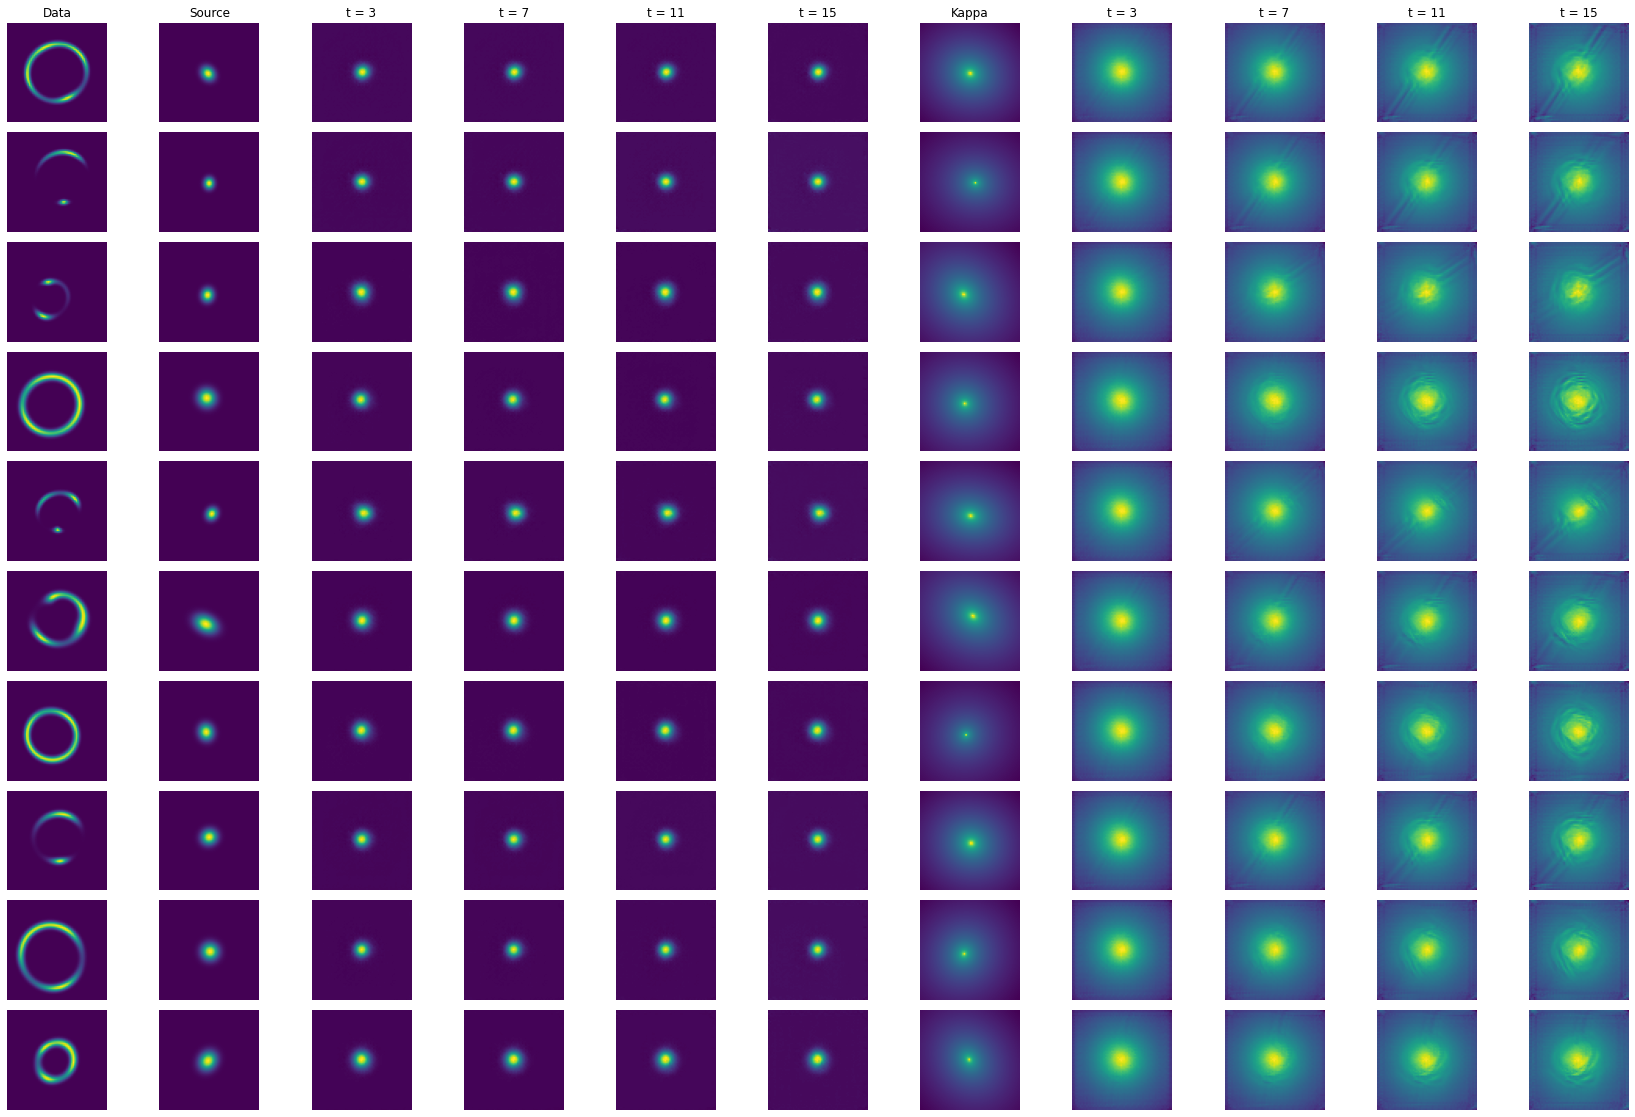

In [12]:
fig, axs = plt.subplots(10, 11, figsize=(30, 20), squeeze=True, gridspec_kw={'wspace':0, 'hspace':0.1})
fig.tight_layout()
for i in range(10):
    X, source, kappa = gen[i]
    source_pred, kappa_pred, cost = rim.forward_pass(X)
    axs[i, 0].imshow(X.numpy()[0, ..., 0], origin="lower")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(source[0, ..., 0], origin="lower")
    axs[i, 1].axis("off")
    for j in range(4):
        axs[i, 2+j].imshow(source_pred[4*(j+1)-1][0, ..., 0], origin="lower")
        axs[i, 2+j].axis("off")
        if i == 0:
            axs[0, 2+j].set_title(f"t = {4*(j+1)-1}")

    axs[i, 3+j].imshow( tf.math.log(kappa.numpy()[0, ..., 0] + 1e-10) / tf.math.log(10.), origin="lower")
    axs[i, 3+j].axis("off")
    for k in range(4):
        axs[i, 4+j+k].imshow(kappa_pred[4*(k+1)-1].numpy()[0, ..., 0], origin="lower")
        axs[i, 4+j+k].axis("off")
        if i == 0:
            axs[0, 4+j+k].set_title(f"t = {4*(k+1)-1}")    

axs[0, 0].set_title("Data")
axs[0, 1].set_title("Source")

axs[0, 3+j].set_title("Kappa");


<ipython-input-18-e5facc59f9c6>:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


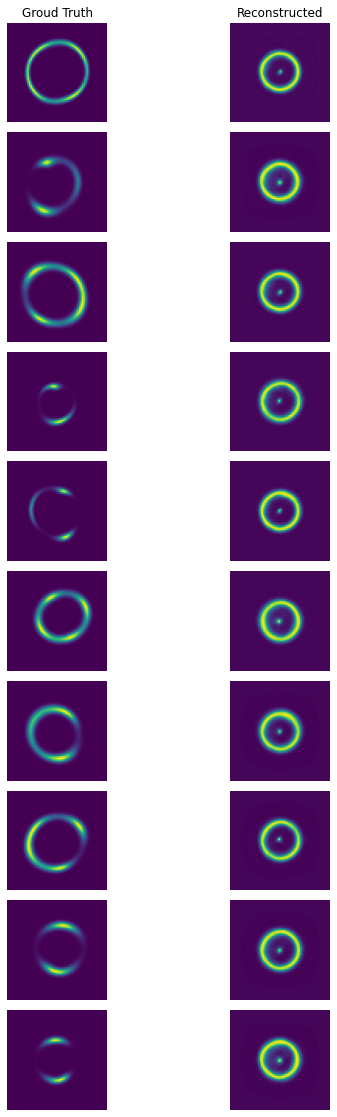

In [18]:
fig, axs = plt.subplots(10, 2, figsize=(8, 20), squeeze=True, gridspec_kw={'wspace':0, 'hspace':0.1})
fig.tight_layout()
for i in range(10):
    X, source, kappa = gen[i]
    source_pred, kappa_pred, cost = rim.forward_pass(X)
    X_pred = rim.physical_model.forward(source_pred[-1], 10**kappa_pred[-1])
    axs[i, 0].imshow(X[0, ..., 0], origin="lower")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(X_pred[0, ..., 0], origin="lower")
    axs[i, 1].axis("off")
#     for j in range(4):
#         axs[i, 2+j].imshow(source_pred[4*(j+1)-1][0, ..., 0], origin="lower")
#         axs[i, 2+j].axis("off")
#         if i == 0:
#             axs[0, 2+j].set_title(f"t = {4*(j+1)-1}")

#     axs[i, 3+j].imshow( tf.math.log(kappa.numpy()[0, ..., 0] + 1e-10) / tf.math.log(10.), origin="lower")
#     axs[i, 3+j].axis("off")
#     for k in range(4):
#         axs[i, 4+j+k].imshow(kappa_pred[4*(k+1)-1].numpy()[0, ..., 0], origin="lower")
#         axs[i, 4+j+k].axis("off")
#         if i == 0:
#             axs[0, 4+j+k].set_title(f"t = {4*(k+1)-1}")    

axs[0, 0].set_title("Groud Truth")
axs[0, 1].set_title("Reconstructed");

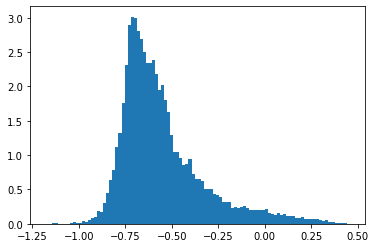

In [19]:
plt.hist(kappa_pred[-1].numpy().ravel(), bins=100, density=True);
# plt.yscale("log")

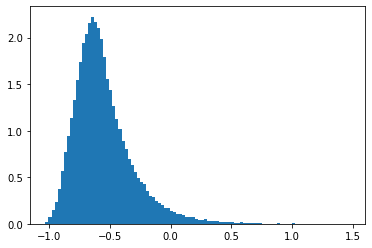

In [20]:
plt.hist(np.log10(kappa.numpy().ravel() + 1e-10), bins=100, density=True);
# plt.yscale("log")

(-0.5, 63.5, 63.5, -0.5)

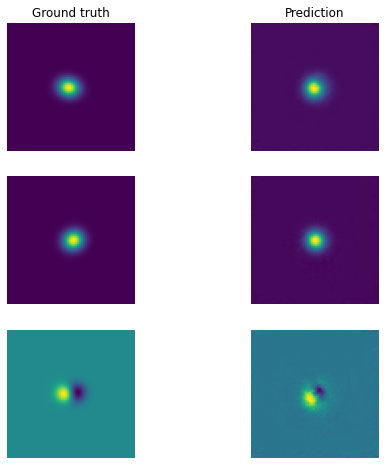

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs[0, 0].imshow(source[0, ..., 0])
axs[0, 0].axis("off")
axs[0, 0].set_title("Ground truth")
axs[0, 1].imshow(source_pred[-1][0, ..., 0])
axs[0, 1].axis("off")
axs[0, 1].set_title("Prediction")
axs[1, 0].imshow(source[1, ..., 0])
axs[1, 0].axis("off")
axs[1, 1].imshow(source_pred[-1][1, ..., 0])
axs[1, 1].axis("off")
axs[2, 0].imshow(source[0, ..., 0] - source[1, ..., 0])
axs[2, 0].axis("off")
axs[2, 1].imshow(source_pred[-1][0, ..., 0] - source_pred[-1][1, ..., 0])
axs[2, 1].axis("off")

(-0.5, 63.5, 63.5, -0.5)

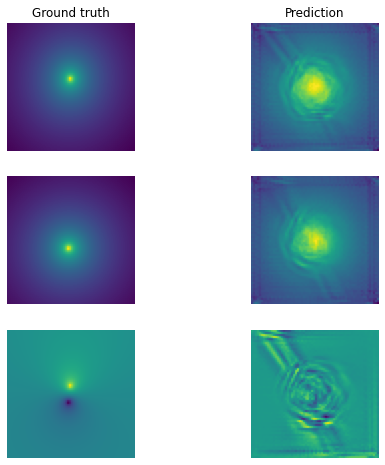

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs[0, 0].imshow(tf.math.log(kappa[0, ..., 0] + 1e-10) / tf.math.log(10.))
axs[0, 0].axis("off")
axs[0, 0].set_title("Ground truth")
axs[0, 1].imshow(kappa_pred[-1][0, ..., 0])
axs[0, 1].axis("off")
axs[0, 1].set_title("Prediction")
axs[1, 0].imshow(tf.math.log(kappa[6, ..., 0] + 1e-10) / tf.math.log(10.))
axs[1, 0].axis("off")
axs[1, 1].imshow(kappa_pred[-1][6, ..., 0])
axs[1, 1].axis("off")
axs[2, 0].imshow(tf.math.log(kappa[0, ..., 0] + 1e-10) / tf.math.log(10.) - tf.math.log(kappa[6, ..., 0] + 1e-10) / tf.math.log(10.))
axs[2, 0].axis("off")
axs[2, 1].imshow(kappa_pred[-1][0, ..., 0] - kappa_pred[-1][6, ..., 0])
axs[2, 1].axis("off")